### HUYNNH Minh-Hoang

In [81]:
from skimage import io, filters, morphology
import numpy as np
import matplotlib.pyplot as plt

# Introduction au traitement d'image : Examen pratique 2023 

## Segmentation d'une image MR

### 1. Histogramme de `jambe.png`

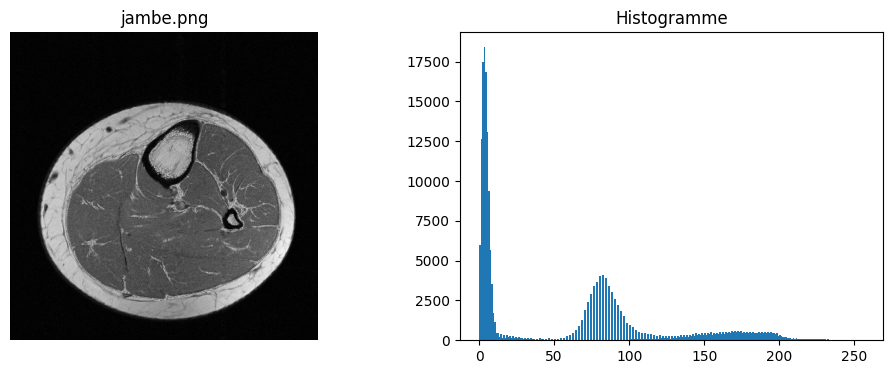

In [12]:
jambe = io.imread('jambe.png')

_, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].imshow(jambe, 'gray')
ax[0].axis('off')
ax[0].set_title('jambe.png')
ax[1].hist(jambe.flatten(), 256, range=(0,256))
ax[1].set_title('Histogramme')
plt.show()


### 2. Segmentation manuelle

On cherche à effectuer un thresholding, étant donnée que l'on distingue au moins trois classes d'intensité de gris. Onvoit graphiquement que l'on peut prendre pour seuil `threshold1 = 45` et `threshhold2 = 125` environ

In [62]:
print(filters.threshold_multiotsu(jambe))

[ 44 129]


En comparaison, la méthode `threshold_multiotsu` renvoie `44` et `129`.

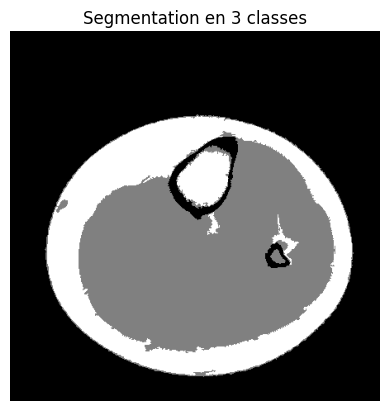

In [123]:
def manual_thresholding(threshold1, threshold2):
    jambe_seg1 = jambe < threshold1
    jambe_seg3 = jambe > threshold2

    jambe_seg2 = jambe_seg1.copy()                                              # Jambe_seg2 correspond à
    for i in range(len(jambe_seg2)):                                            # threshold1 < jambe < threshold2
        for j in range(len(jambe_seg2[0])):
            jambe_seg2[i,j] = not(jambe_seg1[i,j]) and not(jambe_seg3[i,j])

    jambe_seg3 = morphology.remove_small_holes(jambe_seg3, 150)                 # On retire les trous et les objets dont
    jambe_seg3 = morphology.remove_small_objects(jambe_seg3, 150)               # la taille est inférieure à 150
    jambe_seg1 = morphology.remove_small_holes(jambe_seg1, 150)
    jambe_seg1 = morphology.remove_small_objects(jambe_seg1, 150)
    jambe_seg = np.where(jambe_seg1, 0, np.where(jambe_seg3, 255, 128))

    plt.imshow(jambe_seg, 'gray')
    plt.axis('off')
    plt.title('Segmentation en 3 classes')

manual_thresholding(45, 125)

En blanc sont affiché les 3 classes de gris respectives.

### 3. Seuillage automatique (autothreshold)

On tente de rechercher le seuil en faisant la moyenne des moyennes des partitions. 

In [130]:
def threshold_auto(image, thr):
    threshold1 = 0.25*(np.max(image) + np.min(image))                     # En entré, on partitionne de manière à avoir
    threshold2 = 0.75*(np.max(image) + np.min(image))                     # 0-25, 25-75, 75-100
    done = False
    while not done:
        G1, G3 = (image < threshold1), (image > threshold2)
        G2 = G1.copy()
        for i in range(len(G2)):
            for j in range(len(G2[0])):
                G2[i,j] = not(G1[i,j]) and not(G3[i,j])
    
        threshold1_new = 0.5*(np.mean(image[G1])+np.mean(image[G2]))
        threshold2_new = 0.5*(np.mean(image[G2])+np.mean(image[G3]))     
        if abs(threshold1_new-threshold1) < 0.5 and abs(threshold2_new-threshold1) < 0.5 :                         # Dès que l'écart de convergence est < 0.5, 
            done = True
            return int(threshold1_new), int(threshold2_new)
        threshold1 = threshold1_new
        threshold2 = threshold2_new
    

Malheurseusement la fonction ne semble pas converger

In [134]:
threshold_auto(jambe)

KeyboardInterrupt: 

### 4.

Une autre méthode pourrait être la recherche de minimum local que l'on pourrait réaliser par dichotomie avec deux valeurs en entrée